# **Monte Carlo Localization**
_Projekt zaliczeniowy dla przedmiotu "Podstawy metod Monte Carlo w języku Python", Franciszek Urbański, 11.06.2023_
## Wstęp
Aby robot mógł w pełni autonomicznie poruszać się po danym środowisku, musi on wiedzieć, gdzie dokładnie w tym środowisku się znajduje. Jest to niezmiernie ważne zagadnienie i istnieje wiele sposobów jego rozwiązania. 

Bardzo skutecznymi metodami lokalizacji robota są metody probabilistyczne, w tym przedstawiona niżej metoda lokalizacji przy użyciu metody Monte Carlo (Monte Carlo Localization - MCL).

## Zasada działania
Załóżmy, że robot posiada mapę środowiska w którym się znajduje. Nie zna jednak swojej lokalizacji w nim - może tylko wykonywać lokalne pomiary otoczenia. Celem algorymu MCL jest wyznaczenie na ich podstawie pozycji robota.

Z każdą iteracją algorytmu robot generuje wiele losowych podejrzeń co do swojej pozycji (ang. _particles_, cząstki). Zaczynamy od jednorodnie rozmieszczonych cząstek w całej przestrzeni. Na początku każdej iteracji robot dokonuje obserwacji otoczenia i odrzuca cząstki, które nie są z nią zgodne. Następnie na podstawie rozmieszczenia nieodrzuconych cząstek estymowana jest funkcja gęstości prawdopodobieństwa pozycji robota, z której losowany jest nowy zbiór cząstek jako reprezentacja tej gęstości. Potem robot przemieszcza się w inne miejsce, koryguje zbiór cząstek o swoje przesunięcie i rozpoczyna proces od nowa. Po kolejnych iteracjach algorytmu cząstki skupiają się coraz bliżej realnej pozycji robota.

Zauważmy że do przechowywania gęstości w tym podejściu wykorzystujemy próbkę cząstek. Ten fakt pozwala zaliczyć ten algorytm do metod Monte Carlo.

Taka reprezentacja gęstości jest dużo bardziej efektywna niż przechowywanie informacji o niej w siatce o stałym rozmiarze komórki:
* pozwala oszczędzić wiele pamięci (nie przechowujemy punktów w miejscach, w których robot na pewno się nie znajduje) 
* osiągnąć większą dokładność (w miejscu gdzie robot się najprawdopodobniej znajduje, losujemy punkty gęściej)

Możemy jednak w pewnych przypadkach (np. gdy żadna z początkowo wylosowanych cząstek nie była wystarczająco blisko rzeczywistej pozycji robota) nie otrzymać poprawnego wyniku.


## Przykład - 1D
Działanie algorytmu zademonstrujmy na uproszczonym modelu rzeczywistości.

Rozważmy robota poruszającego się wzdłuż jednowymiarowego cyklicznego korytarza. W korytarzu tym w pewnych miejscach na ścianie znajdują się drzwi, a robot posiada czujnik do ich wykrywania.

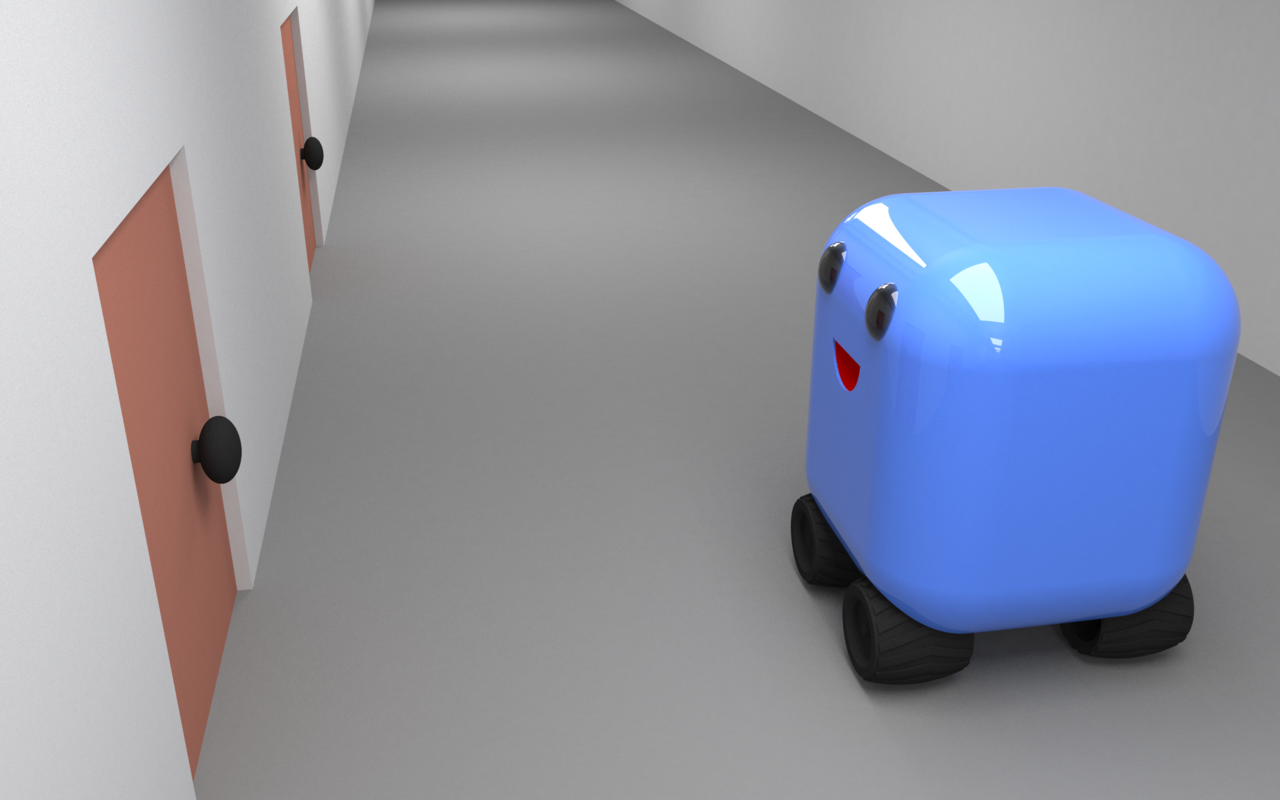
_Żródło: https://en.wikipedia.org/wiki/Monte_Carlo_localization#/media/File:Corridorbot_door.png_

W ramach uproszczenia zakładamy idealną pracę czujnika oraz idealną dokładność poruszania się robota.



### Implementacja

Zacznijmy od zaimportowania potrzebnych nam bibliotek:

In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

Zainicjowania generatora liczb losowych:

In [2]:
seed = None
rng = np.random.default_rng(seed)

Oraz zdefiniowania globalnych parametrów przestrzeni, w której znajduje się robot:

In [3]:
def set_parameters(length, doors, door_width):
    """Sets global parameters for the current problem"""
    global LENGTH
    global DOORS
    global DOOR_WIDTH
    global DISTRIBUTION_GRID
    LENGTH = length
    DOORS = doors
    DOOR_WIDTH = door_width
    DISTRIBUTION_GRID = np.arange(0, length, 0.1)

* `LENGTH` określa długość korytarza w którym się znajdujemy
* `DOORS` to lista przechowująca współrzędne drzwi w naszym korytarzu
* `DOOR_WIDTH` określa jak szerokie są drzwi
* `DISTRIBUTION_GRID` to siatka potrzebna do wyświetlenia funkcji gęstości

Następnie zadeklarujmy kilka funkcji, które będą później przydatne:

In [4]:
def is_at_door(position):
    """Returns whether point at `position` is at door"""
    for d in DOORS:
        # corridor is interpreted as circular, therefore we need three conditions, should a door
        # be at one of the ends of our list
        if abs(d - position) <= DOOR_WIDTH/2 or abs(d - (position - LENGTH)) <= DOOR_WIDTH/2 or abs(d - (position + LENGTH)) <= DOOR_WIDTH/2:
            return True
    return False


def move_robot(position, move):
    """Moves robot from `position` by `move`, returns the new position and new sensor reading"""
    # modulo operation ensures that the robot stays within our circle
    new_position = (position + move) % LENGTH
    sensor = is_at_door(new_position)
    return new_position, sensor


def move_particles(particles, move):
    """Moves set of particles by `move`, returns moved set"""
    # modulo operation ensures that the particles stay within our circle
    particles = (particles + move) % LENGTH
    return particles

* `is_at_door` - zwraca `True` jeżeli punkt dany przez `position` znajduje się w obrębie drzwi, a `False` w przeciwnym przypadku.
* `move_robot` - przesuwa robota znajdującego się w punkcie `position` w kierunku dodatnim o `move`.
* `move_particles` - przesuwa nasz zbiór cząstek `particles` w kierunku dodatnim o `move`, tak aby odpowiadał pozycji robota po przesunięciu o `move`

Jesteśmy teraz gotowi by napisać najbardziej kluczową funkcję naszego algorytmu `generate_particles`, która będzie generować nowy zbiór cząstek w zależności od poprzedniego zbioru cząstek oraz obserwacji otoczenia.

In [5]:
def generate_particles(particles, sensor, bandwidth):
    """Evaluates `particles` based on the `sensor` reading and generates new particles based on the evaluation;
    returns new set of particles and (for visualization purposes) the distribution from which they were drawn"""

    # Evaluate particles - exclude those that are inconsistent with the current sensor reading
    weights = np.zeros(len(particles))
    for i, p in enumerate(particles):
        if is_at_door(p) == sensor:
            weights[i] = 1

    # No particles are consistent with the current sensor reading - we got lost, star over
    if weights.sum() <= 0:
        return rng.random(len(particles)) * LENGTH, np.ones(len(DISTRIBUTION_GRID)) / len(DISTRIBUTION_GRID)

    # Interpolate density from consistent particles and draw new particles
    consistent_particles = particles[weights > 0]
    consistent_particles = np.hstack(  # the corridor is circular, we simulate that by adding copies on both ends
        (consistent_particles - LENGTH, consistent_particles, consistent_particles + LENGTH))
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(
        consistent_particles.reshape(-1, 1))
    # modulo operation ensures that the particles stay within our circle
    new_particles = kde.sample(len(particles)).flatten() % LENGTH

    # calculate distribution for visualization purposes only
    distribution = np.exp(kde.score_samples(DISTRIBUTION_GRID.reshape(-1, 1)).flatten())

    return new_particles, distribution

Przeanalizujmy tę funkcję krok po kroku:
* parametry które przyjmuje funkcja to:
    * `particles` - zbiór cząstek wygenerowanych w poprzedniej iteracji algorytmu
    * `sensor` - pomiar który robot wykonał po przejściu do nowej pozycji
    * `bandwidth` - parametr estymatora jądrowego
* w linijce 6. tworzymy tablicę wag `weights`, która będzie przechowywać informację o zgodności z pomiarem dla kolejnych cząstek (zgodnie z naszym uproszczonym modelem czujnika i ruchu: 0 - punkt niezgodny, 1 - punkt zgodny; w ogólności wagi mogłyby przyjmować inne wartości)
* pętla `for` w linijkach 7-9 przechodzi po wszystkich cząstkach i sprawdza ich zgodność z pomiarem `sensor` - jeżeli dana cząstka jest zgodna, to odpowiadająca jej wartość w tablicy `weights` jest ustawiana na `1`
* w linijce 12. sprawdzamy, czy istnieją cząstki zgodne z pomiarem `sensor`: jeżeli nie, to oznacza że się zgubiliśmy i musimy zacząć od nowa - zwracamy więc nowy losowy zbiór cząstek z rozkładu jednorodnego oraz reprezentację rozkładu jednorodnego (dla celów wizualizacji)
* w linijkach 16-20 dokonujemy estymacji jądrowej rozkładu naszych zgodnych cząstek, by następnie w linijce 22. wybrać nowe cząstki `new_particles` z tego rozkładu
* w linijce 27. zwracamy nowy zbiór cząstek `new particles` oraz zapisaną w linijce 23. reprezentację naszego rozkładu `distribution` (dla celów wizualizacji)

Zobaczmy teraz efekty naszej pracy. Zadeklarujmy:
* funkcję `MCL`, która zaczynając od pozycji początkowej `position` wykona `iterations` iteracji algorytmu (w każdej przesuwając się o `move`, losując `resolution` cząstek, przyjmując parametr estymatora jądrowego `bandwidth`), a następnie zwróci dane potrzebne do wykonania animacji ilustrującej ruch i przewidywania robota, 

In [12]:
def MCL(starting_position, iterations, move, resolution, bandwidth):
    """Performs MCL on situation described by global parameters: `LENGTH`, `DOORS`, `DOOR_WIDTH`"""
    # Performs first iteration without moving the robot
    position = starting_position
    sensor = is_at_door(position)
    particles = rng.random(resolution) * LENGTH
    particles, distribution = generate_particles(particles, sensor, bandwidth)

    # Declares lists storing animation data
    particle_history = [particles]
    position_history = [position]
    distribution_history = [distribution]

    # Performs remaining `iterations - 1` iterations, moving the robot and particles before each iteration
    for _ in range(iterations-1):
        position, sensor = move_robot(position, move)
        particles = move_particles(particles, move)
        particles, distribution = generate_particles(
            particles, sensor, bandwidth)
        particle_history.append(particles)
        position_history.append(position)
        distribution_history.append(distribution)

    return position_history, particle_history, distribution_history

* funkcję `animate`, która z podanych danych stworzy animację (prędkość kontrolowana przez `interval`)  i zapisze ją do pliku `filename`.

In [14]:
def animate(position_history, particle_history, distribution_history, interval, filename):
    """Generates animation, saves it to file specified by `filename`, attempts to display it in the notebook"""
    fig, ax = plt.subplots()

    # Draws doors and floor
    for d in DOORS:
        ax.add_patch(Rectangle((d - DOOR_WIDTH/2, 0.05), DOOR_WIDTH,
                     2*DOOR_WIDTH/LENGTH, facecolor='tab:brown'))
        ax.add_patch(Rectangle((d + LENGTH - DOOR_WIDTH/2, 0.05), DOOR_WIDTH,
                     2*DOOR_WIDTH/LENGTH, facecolor='tab:brown'))
        ax.add_patch(Rectangle((d - LENGTH - DOOR_WIDTH/2, 0.05), DOOR_WIDTH,
                     2*DOOR_WIDTH/LENGTH, facecolor='tab:brown'))
    ax.plot([0, LENGTH], [0.05, 0.05], color='tab:gray', linewidth=1)

    # Generate artists for animation
    artists = []
    for i, p in enumerate(particle_history):
        ax.set_xlim((0, LENGTH))
        ax.set_ylim((0, 1))

        # Draw particles
        container = ax.plot(p, np.zeros(len(
            particle_history[i])) + 0.025, "o", color='tab:red', fillstyle='none', markersize=8, alpha=0.2)
        # Draw robot
        container += ax.plot(position_history[i], 0.055,
                             color='tab:green', markersize=20, marker=7)
        # Draw distribution
        container += ax.plot(DISTRIBUTION_GRID, distribution_history[i]/max(
            distribution_history[i]), color='tab:red', linewidth=1)
        # Draw position prediction
        container += ax.plot(DISTRIBUTION_GRID[np.argmax(
            distribution_history[i])], 0.055, color='tab:red', markersize=10, marker=7)

        artists.append(container)

    # Save animation to file
    anim = animation.ArtistAnimation(
        fig=fig, artists=artists, interval=interval)
    anim.save(filename)
    plt.show()

### Demonstracja
Poniżej znajduje się kilka przykładów działania algorytmu. W razie problemów z wyświetlaniem, pliki .gif z animacjami znajdują się w folderze animations.
#### Legenda:
* **brązowe prostokąty** - drzwi (rzeczywisty rozmiar)
* **zielony trójkąt** - robot (rzeczywista lokalizacja)
* **czerwone**:
    * **okręgi** - cząstki
    * **krzywe** - wykres gęstości cząstek
    * **trójkąt** - robot (przewidywana lokalizacja)

#### Przykład 1.
![Ex. 1](animations/ex1.gif "ex1")

Wygenerowany przez:
```Python
set_parameters(length=20, doors=[2, 10, 12, 17, 19], door_width=1)
position_history, particle_history, distribution_history = MCL(
    starting_position=0, iterations=100, move=0.2, resolution=100, bandwidth=.3)
animate(position_history, particle_history,
        distribution_history, interval=400, filename="anim.gif")
```

Przykład poprawnego działania - na początku lekkie wątpliwości ze względu na niewystarczającą ilość informacji, potem bardzo stabilne

#### Przykład 2.
![Ex. 2](animations/ex2.gif "ex2")

Wygenerowany przez:
```Python
set_parameters(length=20, doors=[3, 5, 7, 12, 14, 18], door_width=1)
position_history, particle_history, distribution_history = MCL(
    starting_position=0, iterations=100, move=0.2, resolution=50, bandwidth=.1)
animate(position_history, particle_history,
        distribution_history, interval=400, filename="anim.gif")
```

Niewiele cząstek, robot robi złą predykcję, przez co w pewnym momencie gubi się, a następnie znajduje od nowa.

#### Przykład 3.
![Ex. 3](animations/ex3.gif "ex3")

Wygenerowany przez:
```Python
set_parameters(length=20, doors=[3, 5, 7, 12, 14, 18], door_width=1)
position_history, particle_history, distribution_history = MCL(
    starting_position=0, iterations=100, move=0.2, resolution=100, bandwidth=.2)
animate(position_history, particle_history,
        distribution_history, interval=400, filename="anim.gif")
```

Po delikatnej zmianie parametrów algorytm stał się dużo skuteczniejszy.

#### Przykład 4.
![Ex. 4](animations/ex4.gif "ex4")

Wygenerowany przez:
```Python
set_parameters(length=20, doors=[4, 8, 12, 16, 20], door_width=1)
position_history, particle_history, distribution_history = MCL(
    starting_position=0, iterations=100, move=0.2, resolution=100, bandwidth=.3)
animate(position_history, particle_history,
        distribution_history, interval=400, filename="anim.gif")
```
Gdy środowisko jest zbyt symetryczne algorytm nie jest skuteczny

#### Przykład ...
Zachęcam do eksperymentowania z wartościami parametrów i tworzenia następnych ciekawych przykładów - efekt pracy zostanie zapisany do pliku `"anim.gif"`

In [ ]:
set_parameters(length=20, doors=[4, 6], door_width=1)
position_history, particle_history, distribution_history = MCL(
    starting_position=0, iterations=100, move=0.2, resolution=100, bandwidth=.3)
animate(position_history, particle_history,
        distribution_history, interval=400, filename="anim.gif")

<div style="text-align: right">
<i> Źródła: <br></i>
<i href="https://www.ri.cmu.edu/pub_files/pub1/dellaert_frank_1999_2/dellaert_frank_1999_2.pdf"> Frank Dellaert, Dieter Fox, Wolfram Burgard, Sebastian Thrun "Monte Carlo Localization for Mobile Robots" <br></i>
<i href="https://en.wikipedia.org/wiki/Monte_Carlo_localization"> Wikipedia <br></i>
</div>